# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></div><div class="lev1 toc-item"><a href="#Set-up-data" data-toc-modified-id="Set-up-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Set up data</a></div><div class="lev2 toc-item"><a href="#Calculate-statistical-clearsky" data-toc-modified-id="Calculate-statistical-clearsky-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Calculate statistical clearsky</a></div><div class="lev2 toc-item"><a href="#Find-data-overlap" data-toc-modified-id="Find-data-overlap-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Find data overlap</a></div><div class="lev2 toc-item"><a href="#Pruned-range" data-toc-modified-id="Pruned-range-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Pruned range</a></div><div class="lev1 toc-item"><a href="#Decision-trees" data-toc-modified-id="Decision-trees-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Decision trees</a></div><div class="lev2 toc-item"><a href="#NSRDB-data" data-toc-modified-id="NSRDB-data-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>NSRDB data</a></div><div class="lev3 toc-item"><a href="#Default-tree" data-toc-modified-id="Default-tree-411"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Default tree</a></div><div class="lev3 toc-item"><a href="#Max-depth-tree" data-toc-modified-id="Max-depth-tree-412"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Max depth tree</a></div><div class="lev2 toc-item"><a href="#Test-on-NSRDB-data" data-toc-modified-id="Test-on-NSRDB-data-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Test on NSRDB data</a></div><div class="lev2 toc-item"><a href="#Test-on-ground-data" data-toc-modified-id="Test-on-ground-data-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Test on ground data</a></div><div class="lev2 toc-item"><a href="#First-run" data-toc-modified-id="First-run-44"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>First run</a></div><div class="lev2 toc-item"><a href="#Second-run" data-toc-modified-id="Second-run-45"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Second run</a></div>

# Introduction

This notebook will explore how closely NSRDB satellite data and RTC ground data agree on irradiance measurements.  We will also look at the agreement between modeled irradiance from NSRDB and that supplied by PVLIB.  Ideally we hope to see that measured irradiances and modeled irradiances are close to one another for both collection methods.  If the NSRDB and ground based RTC data are different, we hope that they are different on a similar scale.

# Load data

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pytz
import itertools

import pvlib
import utils

import model_free

import concurrent.futures

np.set_printoptions(precision=4)
%matplotlib notebook

In [2]:
NSRDB_PATH = os.path.expanduser('~/data_sets/nsrdb/abq_area/')
GROUND_PATH = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')

In [3]:
nsrdb_df = utils.read_dir_nsrdb(NSRDB_PATH, 'US/Mountain')
ground_df = utils.read_snl_rtc(GROUND_PATH, 'Etc/GMT+7', 'US/Mountain')

In [4]:
# rename so GHI is named same as NSRDB
ground_df['GHI'] = ground_df['Global_Wm2']

In [5]:
# filter off below zero irradiance
nsrdb_df[nsrdb_df['GHI'] < 0] = 0
ground_df[ground_df['GHI'] < 0] = 0

In [6]:
def calc_ratio(ser1, ser2):
    ser = (ser1 / ser2).replace([-np.inf, np.inf, np.nan], 0)
    ser = pd.Series(ser, index=ser1.index)
    return ser
    
def calc_abs_ratio_diff(ser1, ser2):
    ratio = calc_ratio(ser1, ser2)
    ser = np.abs(1 - ratio)
    ser = pd.Series(ser, index=ser1.index)
    return ser

# Set up data

## Calculate statistical clearsky

In [7]:
mf = model_free.ModelFreeDetect(nsrdb_df['GHI'])

In [8]:
stat_cs = mf.generate_stat_cs(model_fxn=np.nanpercentile, percentile=90, num_days=14) # , smooth_window=60, smooth_fxn=np.nanmean)

/Users/benellis/miniconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [9]:
nsrdb_df['Clearsky GHI stat'] = stat_cs

In [10]:
mf = model_free.ModelFreeDetect(ground_df['GHI'])

In [11]:
stat_cs = mf.generate_stat_cs(model_fxn=np.nanpercentile, percentile=90, num_days=14, smooth_window=90, smooth_fxn=np.nanmean)

/Users/benellis/miniconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [12]:
ground_df['Clearsky GHI stat'] = stat_cs

## Find data overlap

In [13]:
intersection = nsrdb_df.index.intersection(ground_df.index)
EARLIEST_IDX = intersection[0]
LATEST_IDX = intersection[-1]
print('NSRDB date range: {} -> {}'.format(nsrdb_df.index[0], nsrdb_df.index[-1]))
print('Ground date range: {} -> {}'.format(ground_df.index[0], ground_df.index[-1]))
print('Earliest intersection: {}, latest intersection: {}'.format(EARLIEST_IDX, LATEST_IDX))

NSRDB date range: 1997-12-31 17:00:00-07:00 -> 2015-12-31 16:30:00-07:00
Ground date range: 2015-01-08 22:31:00-07:00 -> 2017-04-06 01:00:00-06:00
Earliest intersection: 2015-01-08 23:00:00-07:00, latest intersection: 2015-12-31 16:30:00-07:00


In [14]:
intersection = intersection[intersection >= '10-01-2015']

Even less overlap than initially thought.  We will set earliest date to be Oct 1, 2015 (overlap before that has obvious issues).  This was established in the 1_abq_data_comparison notebook.

## Pruned range

In [15]:
nsrdb_df['sky_status'] = (nsrdb_df['Cloud Type'] == 0) & (nsrdb_df['GHI'] > 0)

In [16]:
# generate clearsky model for ground-based measurements
# takes a while to generate clearsky curve...
snl_params = {'tilt': 35, 'elevation': 1658, 'azimuth': 180, 'lat': 35.0549, 'lon': -106.5433}
rtc = utils.make_pvlib_sys(**snl_params)
clear_skies = rtc.get_clearsky(ground_df.index)
clear_skies = pd.Series(clear_skies['ghi'])
clear_skies.index = ground_df.index
ground_df['Clearsky GHI'] = clear_skies

In [17]:
ground_df['ratio'] = calc_ratio(ground_df['GHI'], ground_df['Clearsky GHI'])
ground_df['abs_diff_ratio'] = calc_abs_ratio_diff(ground_df['GHI'], ground_df['Clearsky GHI'])
ground_df['ratio stat'] = calc_ratio(ground_df['GHI'], ground_df['Clearsky GHI stat'])
ground_df['abs_diff_ratio stat'] = calc_abs_ratio_diff(ground_df['GHI'], ground_df['Clearsky GHI stat'])

In [18]:
nsrdb_df['ratio'] = calc_ratio(nsrdb_df['GHI'], nsrdb_df['Clearsky GHI'])
nsrdb_df['abs_diff_ratio'] = calc_abs_ratio_diff(nsrdb_df['GHI'], nsrdb_df['Clearsky GHI'])
nsrdb_df['ratio stat'] = calc_ratio(nsrdb_df['GHI'], nsrdb_df['Clearsky GHI stat'])
nsrdb_df['abs_diff_ratio stat'] = calc_abs_ratio_diff(nsrdb_df['GHI'], nsrdb_df['Clearsky GHI stat'])

# Decision trees

In [19]:
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics
from IPython.display import Image

def fit_model(clf, df, cols):
    X = df[cols[:-1]].values
    y = df[cols[-1]].astype(int).values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
    scores = model_selection.cross_val_score(estimator=clf, X=X_train, y=y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_score = metrics.accuracy_score(y_test, y_pred)
    print('CV scoring: {} +/ -  {}'.format(np.round(np.mean(scores), 4), np.round(np.std(scores), 4)))
    print('Test score: {}'.format(test_score))
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])
    return clf

def fit_model_cv_grid(clf, df, cols, param_grid):
    X = df[cols[:-1]].values
    y = df[cols[-1]].astype(int).values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
    clf_cv = model_selection.GridSearchCV(clf, param_grid)
    clf_cv.fit(X_train, y_train)
    # MAX_DEPTH = clf_cv.best_estimator_.max_depth
    y_pred = clf_cv.predict(X_test)
    test_score = metrics.accuracy_score(y_test, y_pred)
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])
    return clf_cv

## NSRDB data

### Default tree

CV scoring: 0.9046 +/ -  0.0012
Test score: 0.9056890781867964


<IPython.core.display.Javascript object>


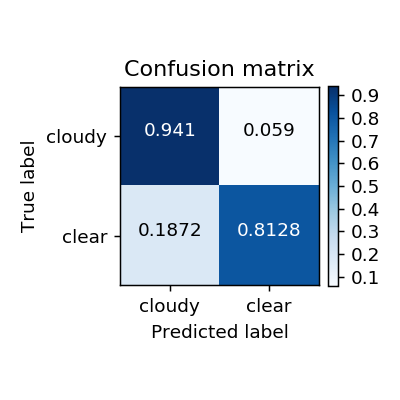

In [20]:
cols = ['GHI', 'Clearsky GHI stat', 'ratio stat', 'sky_status']
dt = tree.DecisionTreeClassifier()
dt = fit_model(dt, nsrdb_df, cols)

Tree is overly complex and difficult to interpret.  Will start by limiting the depth of the tree (using cross val).

### Max depth tree

<IPython.core.display.Javascript object>


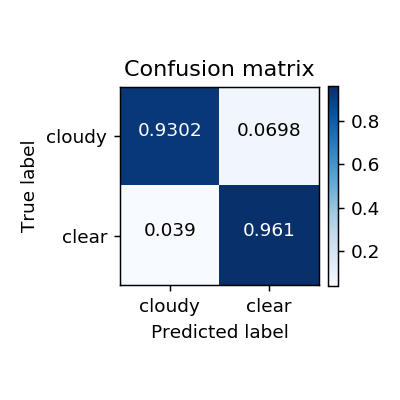

In [21]:
cols = ['GHI', 'Clearsky GHI stat', 'ratio stat', 'sky_status']
param_grid = {'max_depth': [i for i in range(2, 15)]}
dt = tree.DecisionTreeClassifier()
clf_cv = fit_model_cv_grid(dt, nsrdb_df, cols, param_grid)
dt = clf_cv.best_estimator_

In [22]:
print('Optimal max depth: ', dt.max_depth)
MAX_DEPTH = dt.max_depth

Optimal max depth:  7


In [23]:
tree.export_graphviz(dt, out_file='3_abq_opt_dt_stat.dot')
!dot -Tpng 3_abq_opt_dt_stat.dot -o 3_abq_opt_dt_stat.png

!['Optimized decision tree'](3_abq_opt_dt_stat.png)

<IPython.core.display.Javascript object>


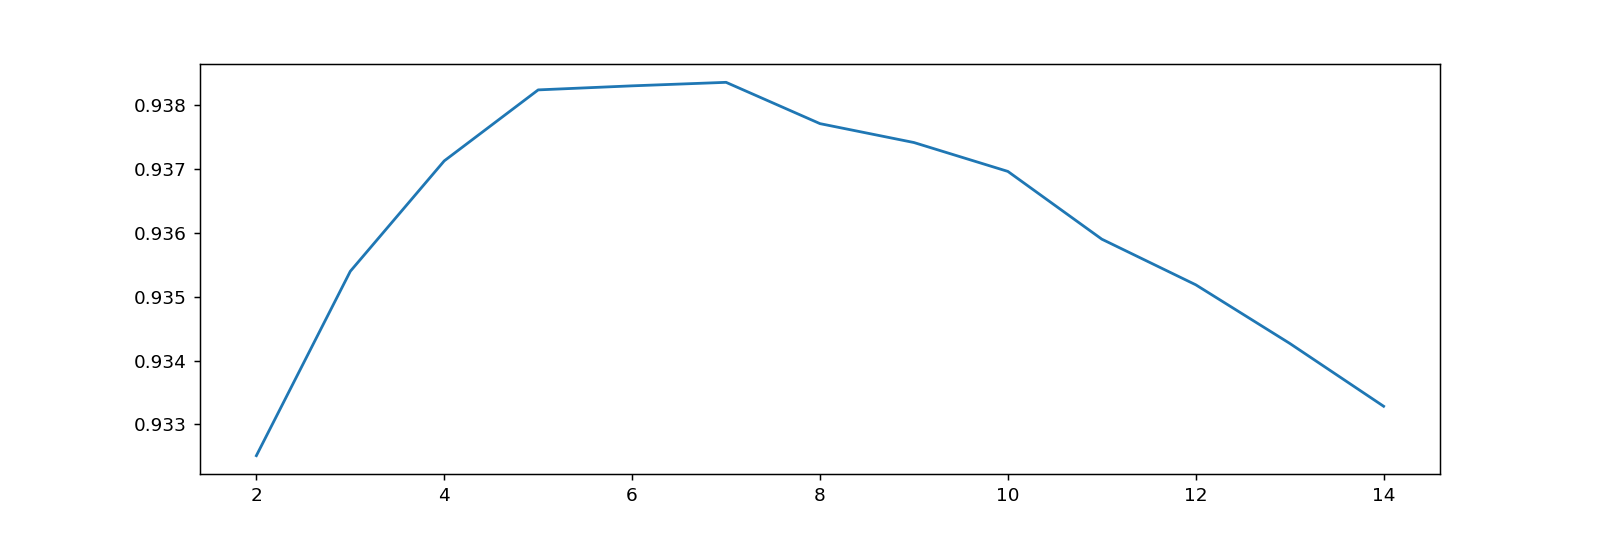

In [24]:
scores = clf_cv.cv_results_['mean_test_score']
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(list(range(2, 15)), scores)

## Test on NSRDB data

In [25]:
train_df = nsrdb_df[nsrdb_df.index < '01-01-2015']
test_df = nsrdb_df[nsrdb_df.index >= '01-01-2015']

In [26]:
cols = ['GHI', 'Clearsky GHI stat', 'ratio stat', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [27]:
predicted_clear = dt.predict(test_df[cols[:-1]])

<IPython.core.display.Javascript object>


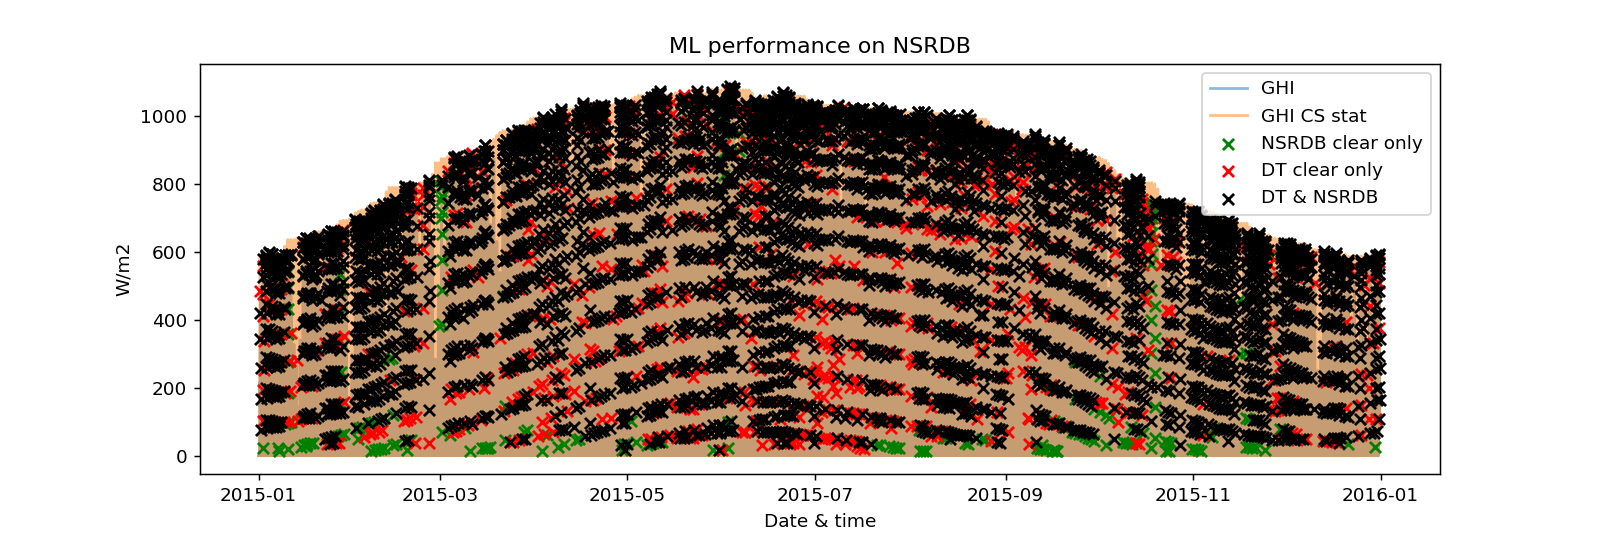

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

p3 = ax.scatter(test_df[~(predicted_clear) & (test_df['sky_status'] == 1)].index, 
                test_df[~(predicted_clear) & (test_df['sky_status'] == 1)]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(predicted_clear) & ~(test_df['sky_status'] == 1)].index, 
                test_df[(predicted_clear) & ~(test_df['sky_status'] == 1)]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p5 = ax.scatter(test_df[(test_df['sky_status'] == 1) & (predicted_clear)].index,
                test_df[(test_df['sky_status'] == 1) & (predicted_clear)]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


DT missing early morning and late evenings again.  In general though, the performance is very good.  There are limited cases where the DT detection looks incorrect. 

## Test on ground data

## First run

In [29]:
train_df = nsrdb_df
test_df = ground_df[ground_df.index >= '10-01-2015']

In [30]:
# detect clearsky using PVLib for ground measurements as a point of comparison
test_df['pvlib_clear'] = pvlib.clearsky.detect_clearsky(test_df['GHI'], test_df['Clearsky GHI'], test_df.index, 10)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
cols = ['GHI', 'Clearsky GHI stat', 'ratio stat', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [32]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
train_df = train_df.loc[intersection]
test_df = test_df.loc[intersection]

In [34]:
train_df['sky_status'].head()

2015-10-01 00:00:00-06:00    False
2015-10-01 00:30:00-06:00    False
2015-10-01 01:00:00-06:00    False
2015-10-01 01:30:00-06:00    False
2015-10-01 02:00:00-06:00    False
Freq: 30T, Name: sky_status, dtype: bool

<IPython.core.display.Javascript object>


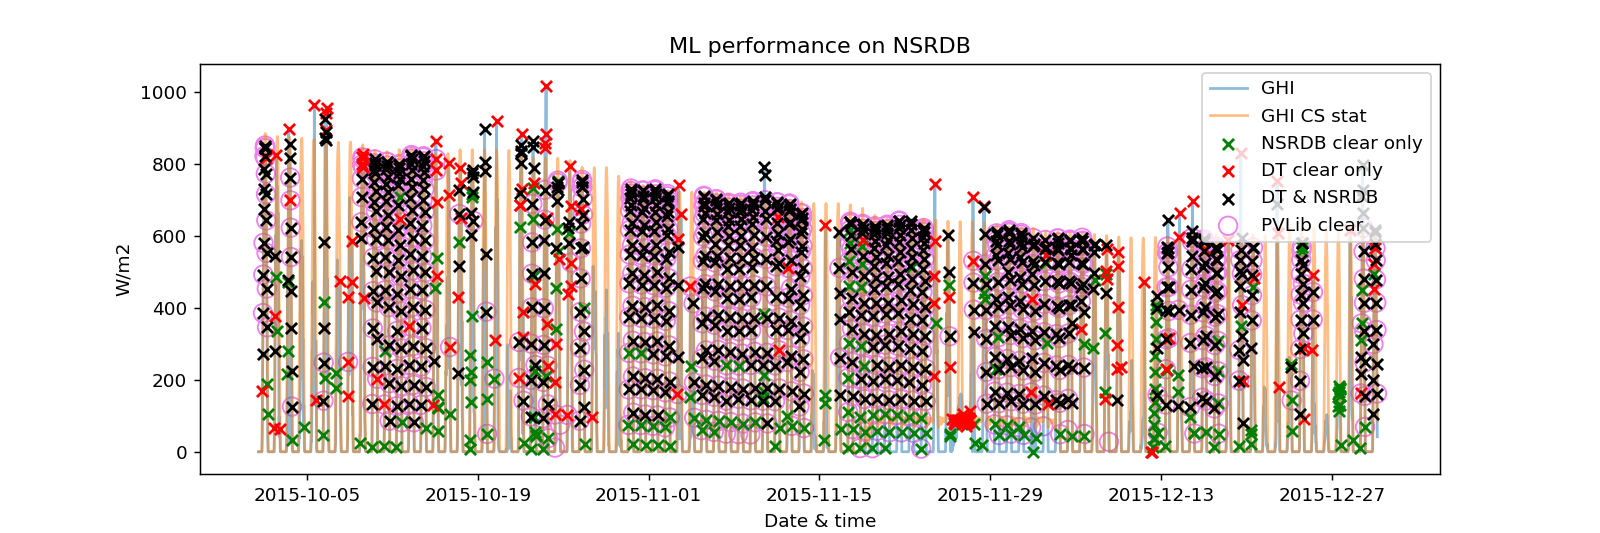

In [35]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

p3 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p5 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

p6 = ax.scatter(test_df[test_df['pvlib_clear']].index,
                test_df[test_df['pvlib_clear']]['GHI'],
                marker='o', edgecolor='violet', facecolor='none', s=100, label='PVLib clear')

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


## Second run

Scale the clearsky model from PVLib using the alpha from the fit of PVLib detection procedure.

In [36]:
train_df = nsrdb_df
test_df = ground_df[ground_df.index >= '10-01-2015']

In [37]:
# detect clearsky using PVLib for ground measurements as a point of comparison
test_df['pvlib_clear'] = pvlib.clearsky.detect_clearsky(test_df['GHI'], test_df['Clearsky GHI'], test_df.index, 10)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
# detect clearsky using PVLib for ground measurements as a point of comparison

# pvlib_clear, _, alpha = pvlib.clearsky.detect_clearsky(test_df['GHI'], test_df['Clearsky GHI'], test_df.index, 10, return_components=True)
# test_df['Clearsky GHI'] *= alpha
# test_df['ratio'] = calc_ratio(test_df['GHI'], test_df['Clearsky GHI'])
# test_df['pvlib_clear'] = pvlib_clear

In [39]:
cols = ['GHI', 'Clearsky GHI stat', 'ratio stat', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [40]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
test_df = test_df[test_df.index < '01-01-2016']

<IPython.core.display.Javascript object>


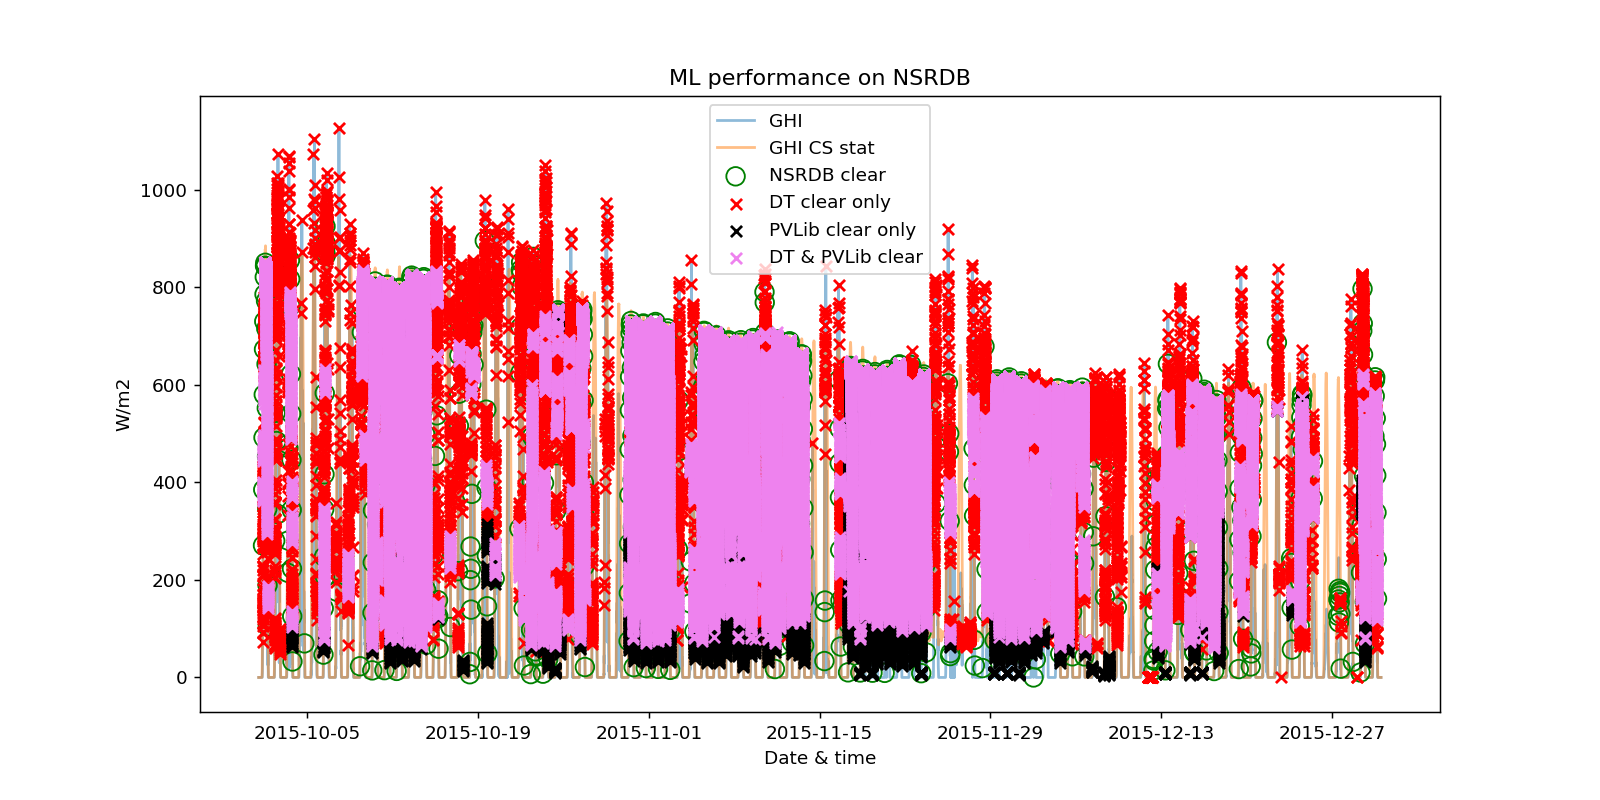

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

p3 = ax.scatter(test_df.loc[train_df[(train_df['sky_status'])].index].index,
                test_df.loc[train_df[(train_df['sky_status'])].index]['GHI'],
                marker='o', edgecolor='green', facecolor='none', label='NSRDB clear', zorder=10, s=100)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~(test_df['pvlib_clear'])].index,
                test_df[(test_df['dt_clear'] == 1) & ~(test_df['pvlib_clear'])]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p4 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & (test_df['pvlib_clear'])].index,
                test_df[~(test_df['dt_clear'] == 1) & (test_df['pvlib_clear'])]['GHI'],
                marker='x', color='black', label='PVLib clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (test_df['pvlib_clear'])].index,
                test_df[(test_df['dt_clear'] == 1) & (test_df['pvlib_clear'])]['GHI'],
                marker='x', color='violet', label='DT & PVLib clear', zorder=10)

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


Model overpredicts irradiances greater than the model curve.